# BERT Model

In [1]:
import os
import re
import torch
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Mount Google Drive
drive.mount("/content/drive")
google_drive_path = "/content/drive/My Drive/UChicago/NLP_Summer_2024/final_project/code"
os.chdir(google_drive_path)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# Check if CUDA (GPU) is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Mounted at /content/drive
Current working directory: /content/drive/My Drive/UChicago/NLP_Summer_2024/final_project/code
Using device: cuda


In [2]:
file_path = "./data/cnn_articles_large_trimmed_labeled_3.csv"
df = pd.read_csv(file_path)

def preprocess_text(text):
    # Remove special characters except apostrophes and hyphens
    text = text.lower()
    text = re.sub(r'[^\w\s\'-]', '', text)
    return text

df["cleaned_text"] = df["Article text"].apply(preprocess_text)

# X_train, X_test, y_train, y_test = train_test_split(df["cleaned_text"], df["y_label_politics"], test_size=0.2, random_state=42)
X_train, X_test, y_train_politics, y_test_politics, y_train_sentiment, y_test_sentiment = train_test_split(
    df["cleaned_text"], df["y_label_politics"], df["y_label_sentiment"], test_size=0.2, random_state=42
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
from torch.utils.data import Dataset

# Define and initialize custom dataset class for training and testing sets
class NewsDataset(Dataset):
    def __init__(self, encodings, labels_politics, labels_sentiment):
        self.encodings = encodings
        self.labels_politics = labels_politics
        self.labels_sentiment = labels_sentiment

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels_politics[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels_politics)

# Convert labels to numeric format
label_to_id_politics = {"liberal": 0, "conservative": 1}
label_to_id_sentiment = {"positive": 0, "negative": 1}

y_train_politics_ids = y_train_politics.map(label_to_id_politics).tolist()
y_test_politics_ids = y_test_politics.map(label_to_id_politics).tolist()

y_train_sentiment_ids = y_train_sentiment.map(label_to_id_sentiment).tolist()
y_test_sentiment_ids = y_test_sentiment.map(label_to_id_sentiment).tolist()

train_dataset = NewsDataset(train_encodings, y_train_politics_ids, y_train_sentiment_ids)
test_dataset = NewsDataset(test_encodings, y_test_politics_ids, y_test_sentiment_ids)



In [4]:
# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./data/bert_base_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./data/bert_logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    save_steps=500,
    eval_steps=500,
    load_best_model_at_end=True,
)

# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [5]:
import time
start_time = time.time()
trainer.train()
end_time = time.time()

training_time = end_time - start_time
print(f"Total training time: {training_time / 60:.2f} minutes")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.186300,0.227065,0.912779,0.790000,0.993711,0.880223
2,0.150800,0.191140,0.916836,0.804124,0.981132,0.883853
3,0.314000,0.214180,0.918864,0.856287,0.899371,0.877301


Total training time: 5.26 minutes


In [6]:
# Evaluate model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.19114041328430176, 'eval_accuracy': 0.9168356997971603, 'eval_precision': 0.8041237113402062, 'eval_recall': 0.9811320754716981, 'eval_f1': 0.8838526912181304, 'eval_runtime': 6.7622, 'eval_samples_per_second': 72.905, 'eval_steps_per_second': 9.169, 'epoch': 3.0}


In [16]:
# Define function to filter and flip false negatives if keywords appear higher than threshold
import json

# Load keywords and phrases
with open("config/keywords.json", "r") as f:
    keywords = json.load(f)

def adjust_predictions_with_keywords(texts, predictions, keywords, sentiment_labels, threshold):
    adjusted_predictions = []
    first = True
    changed_count = 0
    for text, pred, sentiment in zip(texts, predictions, sentiment_labels):
        words = text.split()
        total_words = len(words)
        liberal_count = sum(word in keywords["liberal_keywords"] for word in words)
        conservative_count = sum(word in keywords["conservative_keywords"] for word in words)

        liberal_proportion = liberal_count / total_words
        conservative_proportion = conservative_count / total_words

        if pred == 0:  # liberal prediction
            if liberal_proportion > threshold and sentiment == 1:  # negative sentiment
                adjusted_predictions.append(1)  # conservative
                changed_count += 1
                if first:
                  print(f"liberal proportion: {liberal_proportion}")
                  print("Text: " + text)
                  first = False
            else:
                adjusted_predictions.append(0)  # liberal
        else:  # conservative prediction
            if conservative_proportion > threshold and sentiment == 1:  # negative sentiment
                adjusted_predictions.append(0)  # liberal
            else:
                adjusted_predictions.append(1)  # conservative
    print (f"Number of articles that the filter changed: {changed_count}")
    return adjusted_predictions

# Get model predictions
raw_predictions = trainer.predict(test_dataset).predictions
predictions = torch.argmax(torch.tensor(raw_predictions), axis=1).tolist()

sentiment_labels = y_test_sentiment.map(label_to_id_sentiment).tolist()

# Adjust predictions with keywords and sentiment
adjusted_predictions = adjust_predictions_with_keywords(X_test.tolist(), predictions, keywords, sentiment_labels, 0.05)



Number of articles that the filter changed: 0


In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_custom_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# adjusted_metrics = compute_custom_metrics(adjusted_predictions, y_test_politics_ids)
# print("Adjusted Metrics:", adjusted_metrics)

liberal proportion: 0.00199203187250996
Text:  cnnthe supreme court agreed friday to consider this term whether the biden administration can terminate a trump-era border policy known as remain in mexico a move that calls into question the future of a controversial program that allows officials to send non-mexican migrants to mexico to await their us immigration court hearings the court set the case for argument this aprillower courts have rejected attempts by the biden administration to halt the program forcing the administration to relaunch the policy  under the trump administration thousands of migrants were subject to the program formally known as migrant protection protocols and resided in makeshift camps along mexico's northern border often in squalor and dangerous conditionsdepartment of homeland security rejects gop assertion that terrorism bulletin is attempt to 'police thought'  president joe biden pledged to end the program and began the process of admitting to the united sta

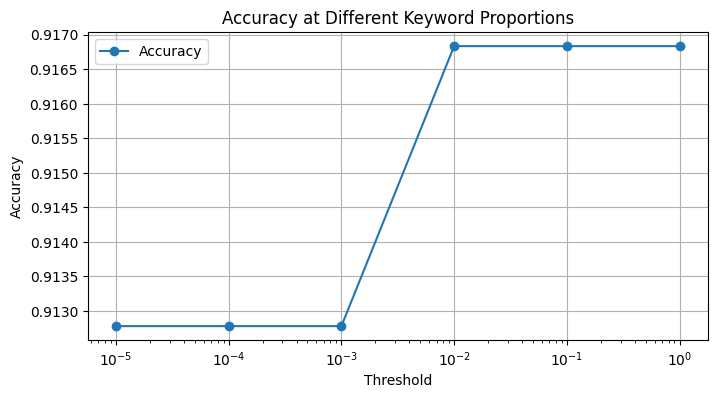

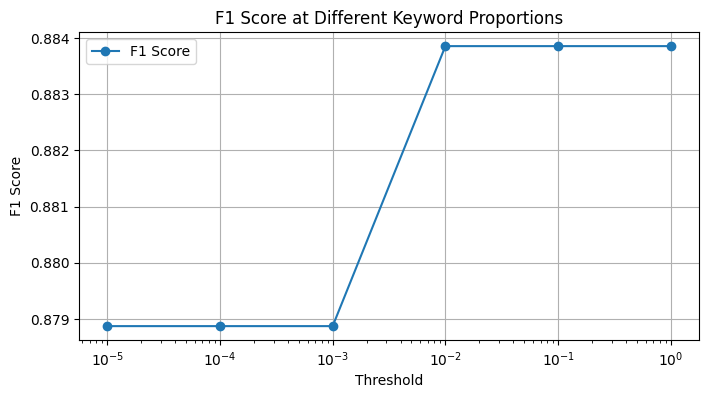

In [17]:
# Optimize threshold by trying different levels to find one that allows the filter to make a difference
import matplotlib.pyplot as plt

# Run evaluations for thresholds from 0.0001% to 10%
thresholds = [1e-05, 1e-04, 1e-03, 0.01, 0.1, 1]
metrics = []

for threshold in thresholds:
    adjusted_predictions = adjust_predictions_with_keywords(X_test.tolist(), predictions, keywords, sentiment_labels, threshold)
    adjusted_metrics = compute_custom_metrics(adjusted_predictions, y_test_politics_ids)
    metrics.append(adjusted_metrics)

# Plot the results
accuracies = [m["accuracy"] for m in metrics]
f1s = [m["f1"] for m in metrics]

print(thresholds)
print(accuracies)
print(f1s)

# Plot Accuracy
plt.figure(figsize=(8, 4))
plt.plot(thresholds, accuracies, label="Accuracy", marker='o')
plt.xscale("log")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy at Different Keyword Proportions")
plt.legend()
plt.grid(True)
plt.savefig("graphs/accuracy_keyword_proportions.png")
plt.show()

# Plot F1 Score
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1s, label="F1 Score", marker='o')
plt.xscale("log")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score at Different Keyword Proportions")
plt.legend()
plt.grid(True)
plt.savefig("graphs/f1_score_keyword_proportions.png")
plt.show()
